1. Create dataset with weak labels


In [1]:
import os
import nibabel as nib
from monai.transforms import Resize, EnsureChannelFirst, Compose, ScaleIntensityRange, AsDiscrete, SpatialCrop, ThresholdIntensity, ShiftIntensity, ScaleIntensity, NormalizeIntensity
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from torch.nn.functional import sigmoid
from torch import nan_to_num
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

/home/francescocremonesiext/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_to_aires_ganglionnaires = '/home/francescocremonesiext/new-areas/aires-ganglionnaires/output/cal_cancer_patients/SEG'
patient_list = os.listdir(path_to_aires_ganglionnaires)

In [3]:
to_remove = []
for i, pat in enumerate(patient_list):
    if len(os.listdir(os.path.join(path_to_aires_ganglionnaires, pat))) < 15:
        to_remove.append(pat)

In [4]:
for rm in to_remove:
    patient_list.pop(patient_list.index(rm))

In [5]:
len(patient_list)

324

## Dataset definition

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from weakly_supervised_library import CAL_WSISDataset

In [8]:
common_shape = (256,256,64)
#common_shape = (32,32,64)
window=350
level=40
whole_dataset = CAL_WSISDataset(
    '/mnt/lvssd/common/AI4PET/data_v1.0.0/data/02_intermediate/CAL/CT',
    path_to_aires_ganglionnaires,
    patient_list,
    'level_iii_left',
    transforms = {
        'data': Compose((
                EnsureChannelFirst(channel_dim='no_channel'),
                Resize(common_shape),
                NormalizeIntensity(subtrahend=level-0.5*window, divisor=window),
                ThresholdIntensity(1, above=False, cval=1),
                ThresholdIntensity(0, above=True, cval=0),
                )),
        'label': Compose((
                EnsureChannelFirst(channel_dim='no_channel'),
                Resize(common_shape),
                AsDiscrete(threshold=0.5),
                )),
    },
    min_crop_shape=common_shape,  # deactivate crop_shape
    force_recompute_bbox=False,
    crop_images=True,
    only_crop_z=False
)



In [9]:
train_indices, test_indices = train_test_split(list(range(len(whole_dataset))), test_size=0.2, random_state=4242)

In [10]:
train_dataset = Subset(whole_dataset, train_indices)
test_dataset = Subset(whole_dataset, test_indices)

In [11]:
len(train_dataset), len(test_dataset)

(259, 65)

In [12]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,  #True
    num_workers=0,
)

## Model

In [13]:
from transformers import SegGptImageProcessor, SegGptForImageSegmentation

In [14]:
model_id = "BAAI/seggpt-vit-large"
image_processor = SegGptImageProcessor.from_pretrained(model_id)
model = SegGptForImageSegmentation.from_pretrained(model_id)

## Inference on trained model

In [15]:
# for validation
dsc = DiceLoss(
    sigmoid=True,
)

In [16]:
img_prompt, lab_prompt = train_dataset[0]

In [17]:
img, lab = test_dataset[0]

In [18]:
slice_ = 32

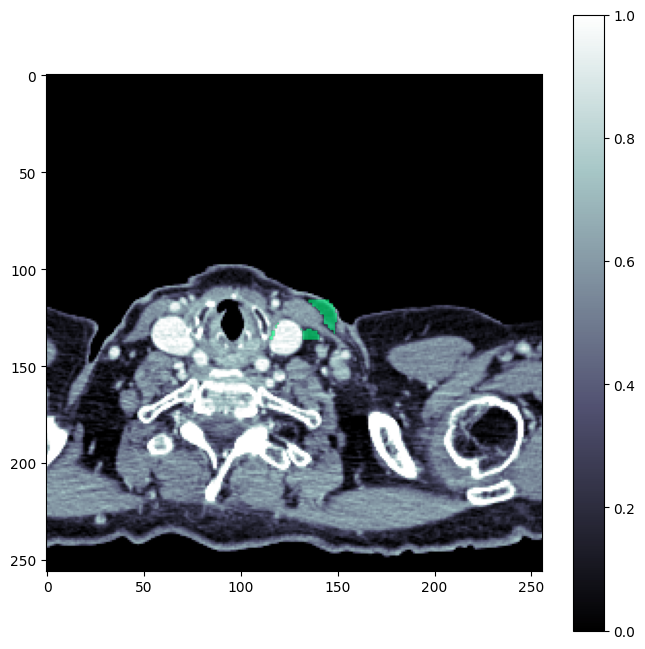

In [19]:
fig, ax = plt.subplots(figsize=(8,8))

npimg = img_prompt[0,...,slice_].numpy()
nplab = lab_prompt[0,...,slice_].numpy()
#bbox_coords = bbox_coords.detach().numpy().squeeze()

ctplot = ax.imshow(npimg.T, cmap='bone')
ax.imshow(np.ma.masked_where(nplab.T < 0.5, 
                             nplab.T), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

fig.colorbar(ctplot)

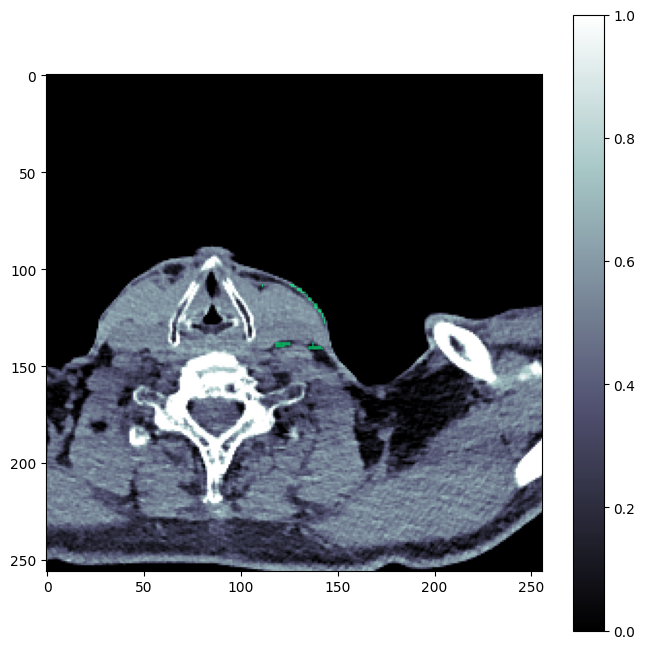

In [20]:
fig, ax = plt.subplots(figsize=(8,8))

npimg = img[0,...,slice_].numpy()
nplab = lab[0,...,slice_].numpy()
#bbox_coords = bbox_coords.detach().numpy().squeeze()

ctplot = ax.imshow(npimg.T, cmap='bone')
ax.imshow(np.ma.masked_where(nplab.T < 0.5, 
                             nplab.T), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

fig.colorbar(ctplot)

#### Try converting to PNG

In [21]:
from PIL import Image

In [57]:
def to_png(x, convert_label=False):
    tensor = x.clone().detach()
    tensor = (tensor - tensor.min())/(tensor.max() - tensor.min())
    np_img = (tensor * 255).numpy().astype(np.uint8)

    #np_img = tensor.numpy()
    rgb_img = np.stack(3*[np_img], axis=-1)

    pil_img = Image.fromarray(rgb_img, 'RGB')
    #pil_img.save('tmp.png')
    #pil_img = Image.open('tmp.png')
    if convert_label:
        pil_img = pil_img.convert('L')
    #pil_img.load()
    return pil_img


In [58]:
img_prompt_png = to_png(img_prompt[0,...,slice_])
lab_prompt_png = to_png(lab_prompt[0,...,slice_], convert_label=False)
img_png = to_png(img[0,...,slice_])
#lab_png = to_png(lab[0,...,slice_])

In [59]:
dd = np.array(img_prompt_png)
dd.shape

(256, 256, 3)

In [60]:
dd = np.array(lab_prompt_png)
dd.shape

(256, 256, 3)

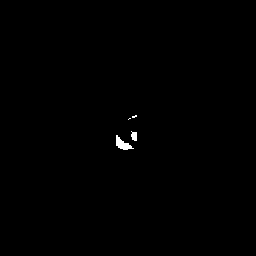

In [61]:
lab_prompt_png


### Define Image Processor inputs

In [218]:
## With PNG 
inputs = image_processor(
    images=img_prompt_png,  # sanity check
    #images=img_png,
    prompt_images=img_prompt_png,
    prompt_masks=lab_prompt_png, 
    num_labels=1,
    return_tensors="pt",
    do_rescale=False,
    #image_mean=[0., 0., 0.],
    #image_std=[1., 1., 1.],
    do_convert_rgb=False,
)

In [140]:
## With PNG and multiple images
inputs = image_processor(
    images=5*[img_prompt_png],
    prompt_images=5*[img_prompt_png],
    prompt_masks=5*[lab_prompt_png], 
    num_labels=1,
    return_tensors="pt",
    do_rescale=False,
    #image_mean=[0., 0., 0.],
    #image_std=[1., 1., 1.],
    do_convert_rgb=False,
    feature_ensemble=True
)

In [26]:
inputs = image_processor(
    #images=torch.stack(3*[img[...,slice_].squeeze()]), 
    images=torch.stack(3*[img_prompt[...,slice_].squeeze()], axis=-1),
    prompt_images=torch.stack(3*[img_prompt[...,slice_].squeeze()], axis=-1),
    prompt_masks=lab_prompt[...,slice_].squeeze().astype(np.uint8), 
    num_labels=1,
    return_tensors="pt",
    do_rescale=False,
    #image_mean=[0., 0., 0.],
    #image_std=[1., 1., 1.],
    #do_convert_rgb=True
)

In [78]:
inputs.keys()

dict_keys(['pixel_values', 'prompt_pixel_values', 'prompt_masks'])

In [ ]:
inputs['pixel_values'].shape

torch.Size([1, 3, 448, 448])

In [79]:
npimg = inputs['pixel_values'][0,0,...]
npimg.shape

torch.Size([448, 448])

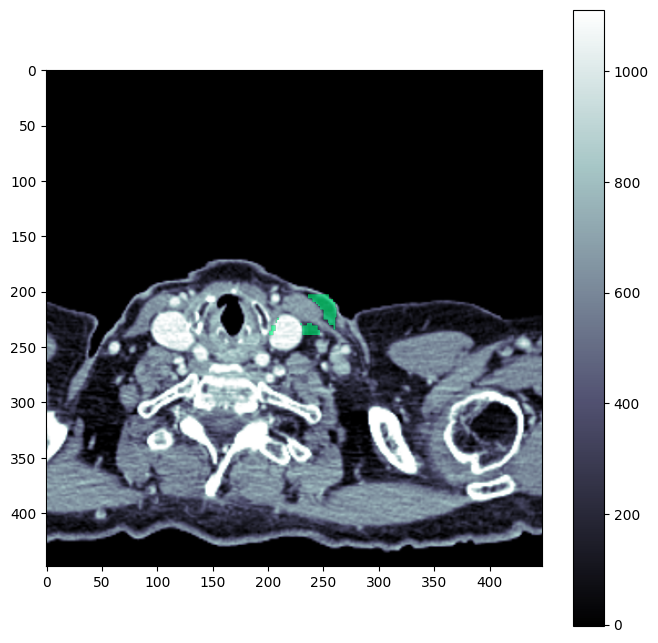

In [64]:
fig, ax = plt.subplots(figsize=(8,8))

npimg = inputs['prompt_pixel_values'][0,0,...]
nplab = inputs['prompt_masks'][0,0,...]
#bbox_coords = bbox_coords.detach().numpy().squeeze()

ctplot = ax.imshow(npimg.T, cmap='bone')
ax.imshow(np.ma.masked_where(nplab.T < 0.5, 
                             nplab.T), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

fig.colorbar(ctplot)

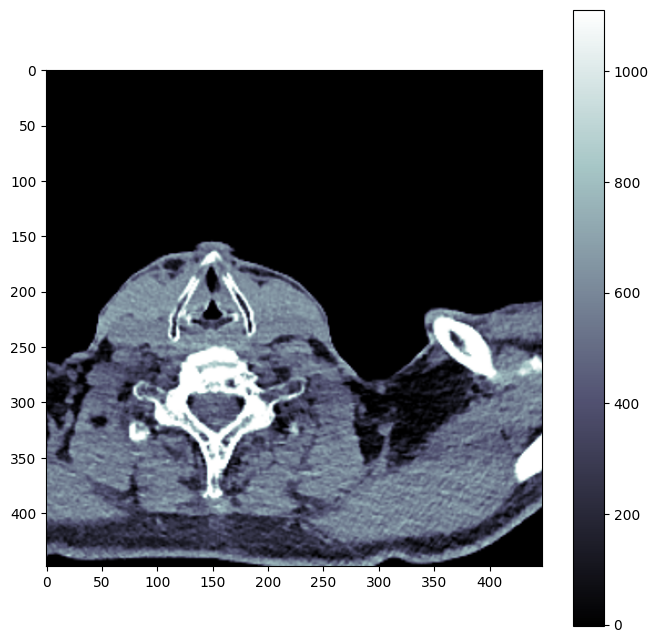

In [65]:
fig, ax = plt.subplots(figsize=(8,8))

npimg = inputs['pixel_values'][0,0,...]

ctplot = ax.imshow(npimg.T, cmap='bone')

fig.colorbar(ctplot)

### Get model outputs

In [219]:
with torch.no_grad():
    outputs = model(**inputs)


In [220]:
outputs['pred_masks'].shape

torch.Size([1, 3, 896, 448])

In [221]:
import copy

In [222]:
new_outputs = copy.deepcopy(outputs)
new_outputs['pred_masks'] = outputs['pred_masks'][-1,...].unsqueeze(dim=0)

In [223]:
new_outputs['pred_masks'].shape

torch.Size([1, 3, 896, 448])

In [224]:
target_sizes = [(img.shape[2],img.shape[1])]
mask = image_processor.post_process_semantic_segmentation(new_outputs, (448,448), num_labels=1)[0]

In [225]:
mask.min(), mask.max()

(tensor(0), tensor(1))

In [226]:
outputs['pred_masks'].min(), outputs['pred_masks'].max()

(tensor(-2.1909), tensor(3.0876))

In [227]:
outputs['pred_masks'].shape

torch.Size([1, 3, 896, 448])

In [228]:
mask.shape

torch.Size([448, 448])

In [229]:
inputs['prompt_pixel_values'][0,0,...].shape

torch.Size([448, 448])

In [230]:
img.shape

torch.Size([1, 256, 256, 64])

In [231]:
inputs['prompt_pixel_values'].shape, inputs['prompt_masks'].shape, inputs['pixel_values'].shape

(torch.Size([1, 3, 448, 448]),
 torch.Size([1, 3, 448, 448]),
 torch.Size([1, 3, 448, 448]))

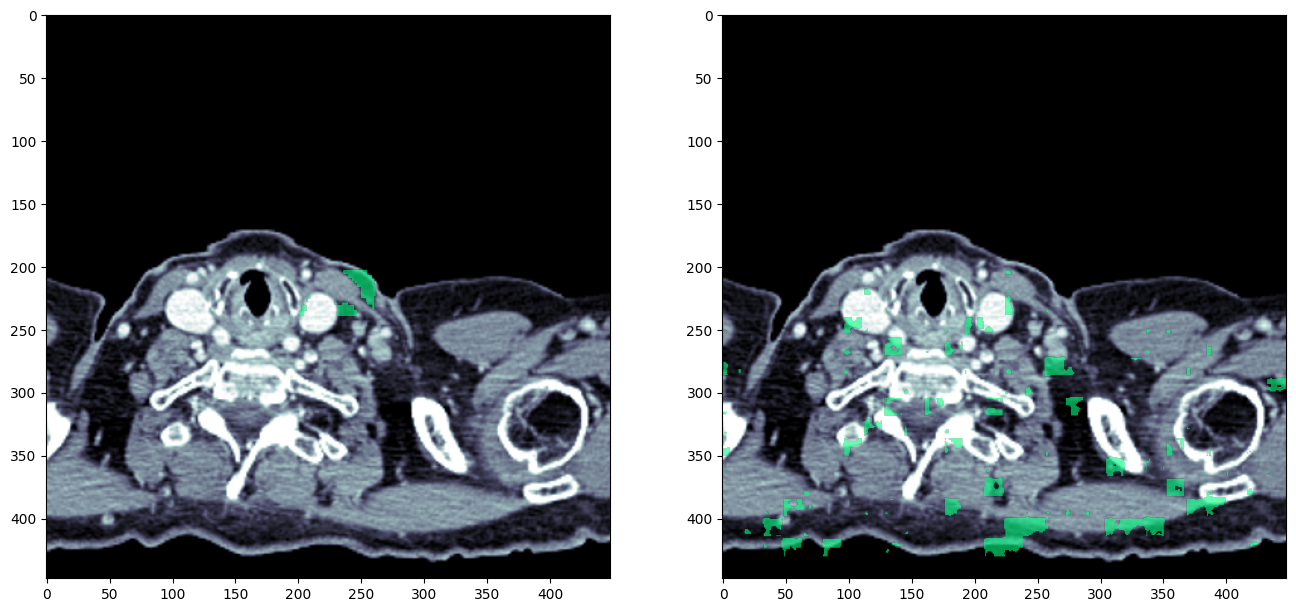

In [232]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

npimg_prompt = inputs['prompt_pixel_values'][0,0,...].detach().clone().numpy()
nplab = inputs['prompt_masks'][0,0,...].detach().clone().numpy()
npimg = inputs['pixel_values'][0,0,...].detach().clone().numpy()
#bbox_coords = bbox_coords.detach().numpy().squeeze()

ctplot = ax[0].imshow(npimg_prompt.T, cmap='bone')
ax[0].imshow(np.ma.masked_where(nplab.T < 0.5, 
                             nplab.T), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

ctplot = ax[1].imshow(npimg.T, cmap='bone')
ax[1].imshow(np.ma.masked_where(mask.T < 0.5, 
                             mask.T), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

#fig.colorbar(ctplot)

In [ ]:
image_processor.post_process_semantic_segmentation()

In [ ]:
image_processor.post_process_semantic_segmentation(outputs, target_sizes, num_labels=1)

[tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]])]

In [ ]:
val_iter = iter(test_dataloader)
model.eval()
with torch.no_grad():
    img, lab, _ = next(val_iter)
    

Validation loss 0.91287351


In [19]:
with torch.no_grad():
    pred_p = sigmoid(pred)
pred_p.max()

metatensor(0.9668)

In [116]:
np.where(nplab > 0)[2].max()

54

NameError: name 'pred_p' is not defined

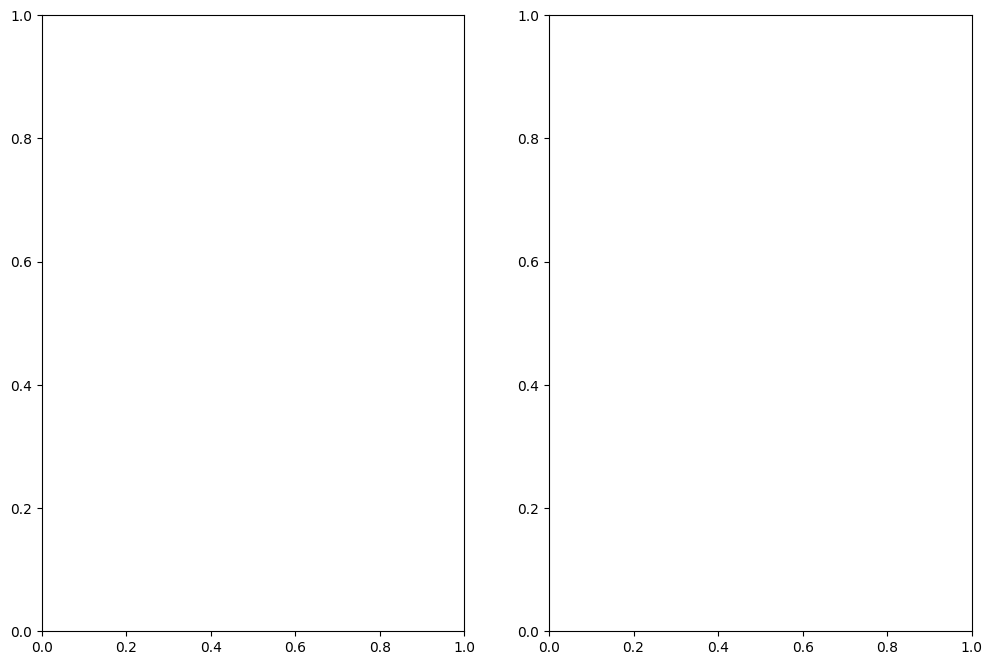

In [71]:
fig, ax = plt.subplots(1,2,figsize=(12,8))

npimg = img.detach().numpy().squeeze()
nppred_p = pred_p.detach().numpy().squeeze()
nplab = lab.detach().numpy().squeeze()

slice_ = np.where(nplab > 0)[2].max() + np.where(nplab > 0)[2].min()
slice_ = int(0.5*slice_)
slice_ = 50

ax[0].imshow(npimg[:,:,slice_], cmap='bone')
ax[0].imshow(np.ma.masked_where(nplab[:,:,slice_] < 0.5, nplab[:,:,slice_]), cmap='winter', alpha=0.5, vmin=0., vmax=1.)

ax[1].imshow(npimg[:,:,slice_], cmap='bone')
ax[1].imshow(np.ma.masked_where(nppred_p[:,:,slice_] < 0.51, nppred_p[:,:,slice_]), cmap='winter', alpha=0.5, vmin=0., vmax=1.)

In [86]:
nppred_p.min(), nppred_p.max()

(0.0, 0.93276536)

In [87]:
nplab.sum()

1615.0

In [88]:
(1-nplab).sum()

33552816.0

In [89]:
nppred_p.sum()

1160.3273

In [90]:
with torch.no_grad():
    l = sz_loss(sigmoid(pred), lab)
l

metatensor([[-2.7002]], dtype=torch.float64)

In [100]:
pred_size = nppred_p.sum()
target_size = nplab.sum()
target_size*0.5, pred_size, target_size/0.5

(807.5, 1160.3273, 3230.0)

In [97]:
t_ = 5.
z = 0.5*target_size - pred_size
mask = (z <= -1./(t_*t_)).astype(np.float64)
l1 = (-1./t_)*np.nan_to_num(np.log(-z))*mask
z, mask, l1

(-352.8272705078125, 1.0, -1.173195723700619)

In [98]:
t_ = 5.
z = 0.5*target_size - pred_size
mask = (z <= -1./(t_*t_)).astype(np.float64)
l1 = (-1./t_)*np.nan_to_num(np.log(-z))*mask
l2 = (t_*z - 1/t_*np.log(1./(t_*t_)) + 1./t_)*(1-mask)
z, mask, l1, l2

(-352.8272705078125, 1.0, -1.173195723700619, -0.0)

In [99]:
t_ = 5.
z = pred_size - target_size/0.5
mask = (z <= -1./(t_*t_)).astype(np.float64)
l1 = (-1./t_)*np.nan_to_num(np.log(-z))*mask
l2 = (t_*z - 1/t_*np.log(1./(t_*t_)) + 1./t_)*(1-mask)
z, mask, l1, l2


(-2069.6727294921875, 1.0, -1.5270291544130858, -0.0)

In [ ]:
class Log_barrier_extension:
    def __init__(self, t, mu):
        self.t= t
        self.mu = mu

    def __call__(self, z):
        mask = (z <= -1./(self.t*self.t)).astype(torch.double)
        return (-1./self.t)*nan_to_num(torch.log(-z))*mask + (self.t*z - 1/self.t*np.log(1./(self.t*self.t)) + 1./self.t)*(1-mask)
    
    def step(self):
        self.t *= self.mu



class Log_barrier_size_constraint_criterion:
    def __init__(self, epsilon=0.5, t = 1., mu=1.):
        self.epsilon = epsilon
        self.barrier = Log_barrier_extension(t, mu)

    def __call__(self, pred, target):
        pred_size = pred.sum(axis=(2,3,4))
        target_size = target.sum(axis=(2,3,4))
        return self.barrier(self.epsilon*target_size - pred_size) + self.barrier(pred_size - target_size/self.epsilon)
    
    def step_barrier(self):
        self.barrier.step()

In [103]:
npimg.max()

350.0

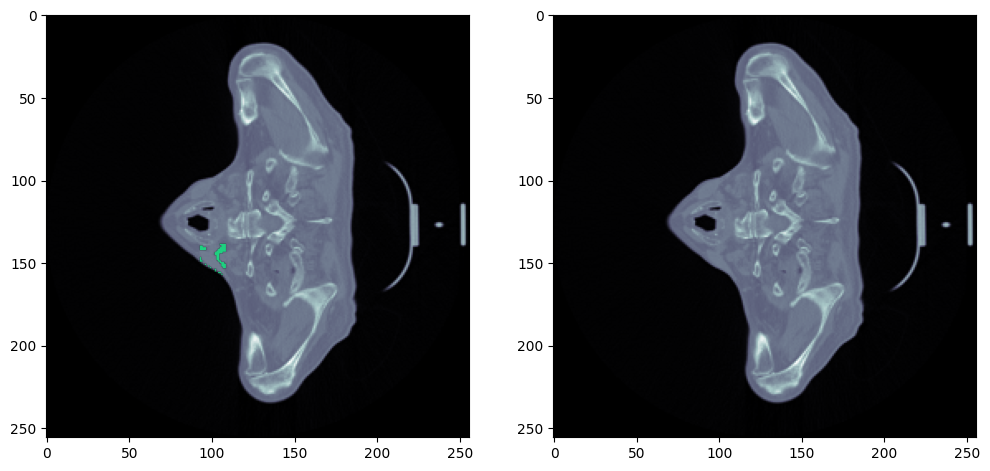

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,8))

npimg = img.detach().numpy().squeeze()
nppred_p = pred_p.detach().numpy().squeeze()
nplab = lab.detach().numpy().squeeze()

slice_ = np.where(nplab > 0)[2].max() + np.where(nplab > 0)[2].min()
slice_ = int(0.5*slice_)


ax[0].imshow(npimg[:,:,slice_], cmap='bone')
ax[0].imshow(np.ma.masked_where(nplab[:,:,slice_] < 0.5, nplab[:,:,slice_]), cmap='winter', alpha=0.7, vmin=0., vmax=1.)

ax[1].imshow(npimg[:,:,slice_], cmap='bone')
ax[1].imshow(np.ma.masked_where(nppred_p[:,:,slice_] < 0.51, nppred_p[:,:,slice_]), cmap='winter', alpha=0.7, vmin=0., vmax=1.)

## Plot one image

In [69]:
val_iter = iter(test_dataloader)
with torch.no_grad():
    img, lab, bbox_coords = next(val_iter)

0, 269, 302
1, 225, 256
2, 697, 726


In [70]:
bbox_coords

tensor([[[269, 225, 680],
         [302, 257, 744]]])

In [62]:
bbox_coords[:,1,:] - bbox_coords[:,0,:]

tensor([[33, 32, 64]])

In [48]:
m = torch.max(bbox_coords[:,1,:] - bbox_coords[:,0,:], axis=-1, )
m[0]

tensor([63])

In [50]:
img.min(), img.max()

(metatensor(0.), metatensor(1.))

In [51]:
lab.min(), lab.max()

(metatensor(0.), metatensor(1.))

In [52]:
npimg.shape

(2, 32, 32, 64)

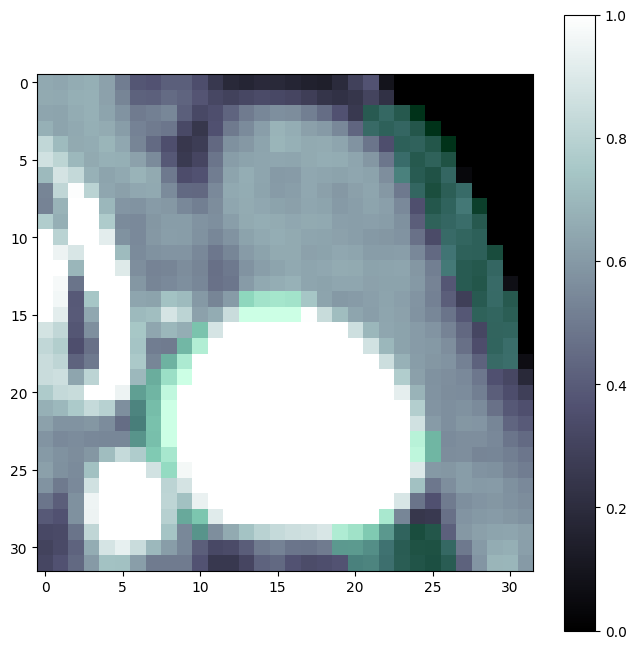

In [53]:
fig, ax = plt.subplots(figsize=(8,8))

npimg = img.detach().numpy().squeeze()
nplab = lab.detach().numpy().squeeze()

slice_ = np.where(nplab > 0)[2].max() + np.where(nplab > 0)[2].min()
slice_ = int(0.5*slice_)
#slice_ = 0
#slice_ = -1

ctplot = ax.imshow(npimg[:,:,slice_].T, cmap='bone')
ax.imshow(np.ma.masked_where(nplab[:,:,slice_].T < 0.5, nplab[:,:,slice_].T), cmap='winter', alpha=0.2, vmin=0., vmax=1.)

fig.colorbar(ctplot)

In [101]:
whole_dataset.patients[test_indices[0]]

'0007010_20200609'

In [102]:
slice_

0

## Reproduce original code

In [44]:
from datasets import load_dataset


dataset_id = "EduardoPacheco/FoodSeg103"
ds = load_dataset(dataset_id, split="train")
# Number of labels in FoodSeg103 (not including background)
num_labels = 103

image_input = ds[4]["image"]
ground_truth = ds[4]["label"]
image_prompt = ds[29]["image"]
mask_prompt = ds[29]["label"]

inputs = image_processor(
    images=image_input, 
    prompt_images=image_prompt,
    prompt_masks=mask_prompt, 
    num_labels=num_labels,
    return_tensors="pt"
)

with torch.no_grad():
    outputs = model(**inputs)

target_sizes = [image_input.size[::-1]]
mask = image_processor.post_process_semantic_segmentation(outputs, target_sizes, num_labels=num_labels)[0]


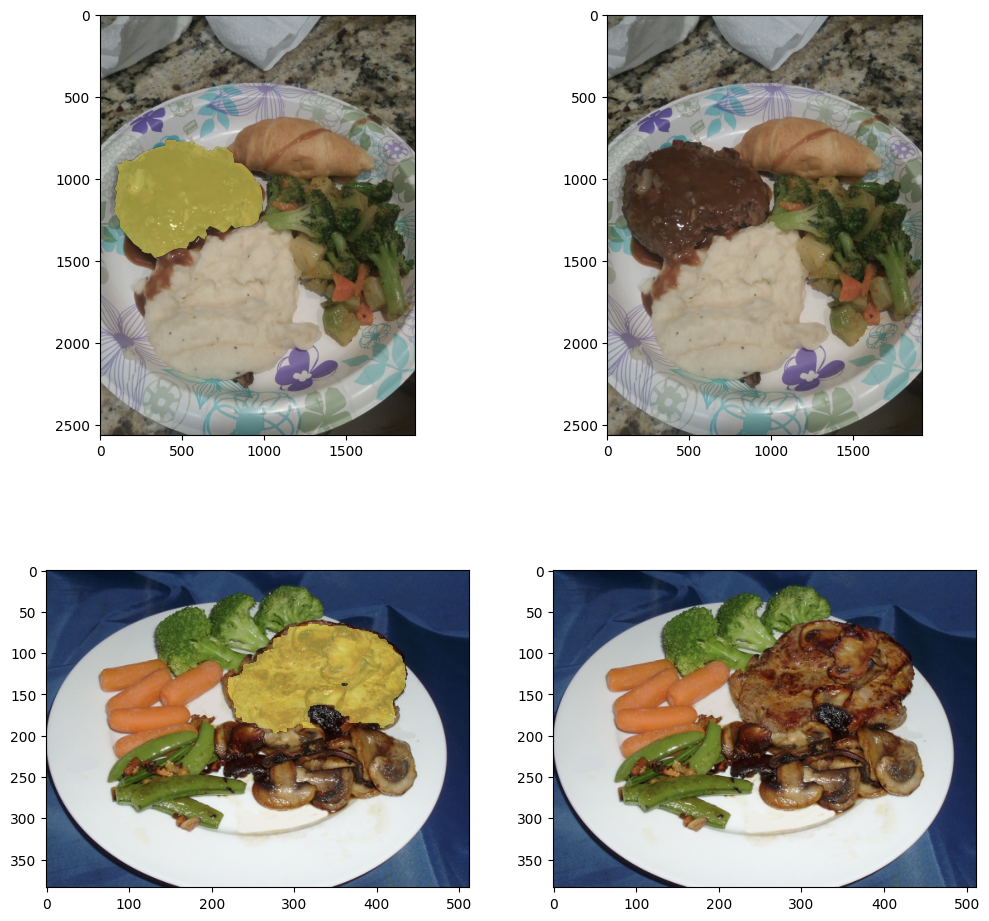

In [64]:
fig, ax = plt.subplots(2,2,figsize=(12,12))

npimg_prompt = np.array(image_prompt)
npmask_prompt = np.array(mask_prompt)
npimg = np.array(image_input)
npmask = np.array(mask)

ax[0][0].imshow(npimg_prompt)
ax[0][1].imshow(npimg_prompt)
ax[0][0].imshow(np.ma.masked_where(npmask_prompt < 0.5, np.ma.masked_where(npmask_prompt > 46.5, npmask_prompt)), cmap='summer', alpha=0.5, vmin=0, vmax=1)

ax[1][0].imshow(npimg)
ax[1][1].imshow(npimg)
ax[1][0].imshow(np.ma.masked_where(npmask < 0.5, np.ma.masked_where(npmask > 46.5, npmask)), cmap='summer', alpha=0.5, vmin=0, vmax=1)

